In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

import warnings
warnings.simplefilter('ignore')

## 1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

# 1.1

In [2]:
#my_PJME_MW = 'my_PJME_MW.csv'
my_PJME_MW = 'my_PJME_MW.csv'
data = pd.read_csv(my_PJME_MW, index_col=[0], parse_dates=[0])

data.head()



,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


In [4]:
d_data = data.resample('D').mean()
d_data.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-01,31080.739130,2002.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,1.0,0.0,0.0
2002-01-02,34261.541667,2002.0,1.0,2.0,1.0,2.0,1.0,2.0,11.5,0.0,0.0,1.0
2002-01-03,34511.875000,2002.0,1.0,3.0,1.0,3.0,1.0,3.0,11.5,0.0,0.0,0.0
2002-01-04,33715.458333,2002.0,1.0,4.0,1.0,4.0,1.0,4.0,11.5,0.0,0.0,0.0
2002-01-05,30405.125000,2002.0,1.0,5.0,1.0,5.0,1.0,5.0,11.5,0.0,0.0,0.0


# 1.2 сглаживание - строим data_exp_1

In [5]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [41]:
data_exp_1 = exponential_smoothing(d_data['PJME_MW'], 0.05)


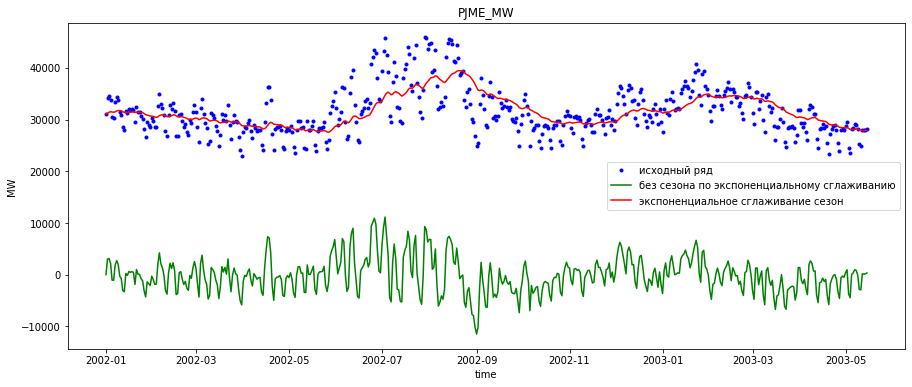

In [7]:
plt.figure(figsize=(15, 6))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], 
         '.b', label='исходный ряд')

plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500] - data_exp_1[:500], 
         color = 'green', label="без сезона по экспоненциальному сглаживанию")

plt.plot(d_data.index[:500], data_exp_1[:500], 
         color = 'red', label="экспоненциальное сглаживание сезон")

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW');

In [8]:
df = pd.DataFrame(data_exp_1, index=d_data.index)
df.head()

,0
Date,
2002-01-01,31080.739130
2002-01-02,31239.779257
2002-01-03,31403.384044
2002-01-04,31518.987759
2002-01-05,31463.294621


# 1.3 Добавим немного признаков из истории - значения ряда 1, 2, 3 шага назад - можно больше - это пример, как добавить

In [9]:
p=14
for i in range(p):
    df['t'+str(i)] = 0
    df['t'+str(i)].values[i+1:]=df.iloc[:-(i+1),0].values
d_1=df.iloc[:,0].diff(1)
d_1[0]=0
for i in range(p):
    df['d'+str(i+1)] = 0
    df['d'+str(i+1)].values[i+1:]=d_1[:-(i+1)]  

df.fillna(0)

df.head(10)

,0,t0,t1,t2,t3,t4,t5,t6,t7,t8,...,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,31080.739130,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-02,31239.779257,31080,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-03,31403.384044,31239,31080,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-04,31518.987759,31403,31239,31080,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-05,31463.294621,31518,31403,31239,31080,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-06,31406.309057,31463,31518,31403,31239,31080,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-07,31502.685270,31406,31463,31518,31403,31239,31080,0,0,0,...,159,0,0,0,0,0,0,0,0,0
2002-01-08,31645.696840,31502,31406,31463,31518,31403,31239,31080,0,0,...,163,159,0,0,0,0,0,0,0,0
2002-01-09,31752.220331,31645,31502,31406,31463,31518,31403,31239,31080,0,...,115,163,159,0,0,0,0,0,0,0


In [10]:
# сделаем примеры для теста и тренировки 
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [11]:
train, test = split_data(df, '2017-01-01')

### 1.4 прогноз  h = 1 - горизонт предсказания 1 шаг вперед

In [12]:
h = 1

In [13]:
X_train_1 = train.iloc[:-h,:]
y_train_1 = train[df.columns[0]].values[h:]
X_test_1 = test.iloc[:-h,:]
y_test_1 = test[df.columns[0]].values[h:]

In [14]:
stsc = StandardScaler()

In [15]:
X_train_1 = stsc.fit_transform(X_train_1)

X_test_1 = stsc.transform(X_test_1)

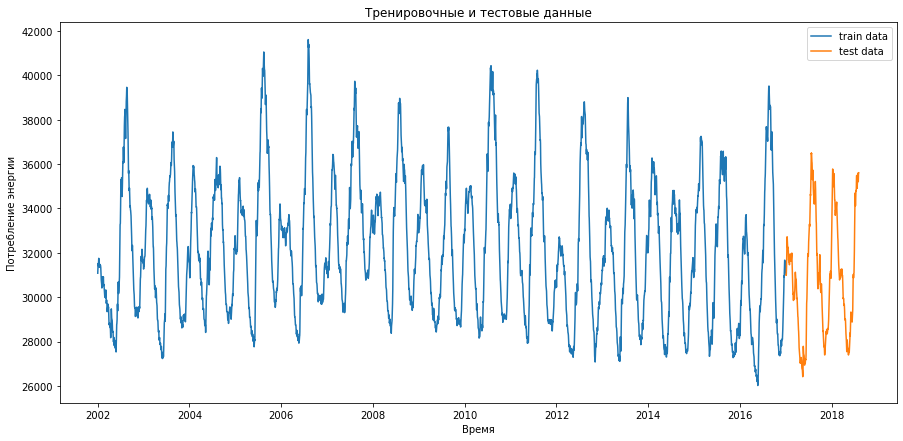

In [16]:
plt.figure(figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(train.index.get_level_values('Date'), train[0], label='train data' )
plt.plot(test.index.get_level_values('Date'), test[0], label='test data')
plt.title('Тренировочные и тестовые данные')
plt.legend();

Метрика для оценки качества предсказания - MAPE - работает только для ряда, где все значения больше 1

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Построим модель - не всегда лучше GradientBoostingRegressor - часто хорошо работает линейная регрессия.

In [18]:
model_gb = GradientBoostingRegressor(max_depth=25, random_state=0, n_estimators=500)

In [19]:
# model_gb.fit(X_train_1[:,:], y_train_1[:]) 
# X_test_pred_gb = model_gb.predict(X_test_1)

In [20]:
model_gb.fit(X_train_1, y_train_1) 
X_test_pred_gb = model_gb.predict(X_test_1)


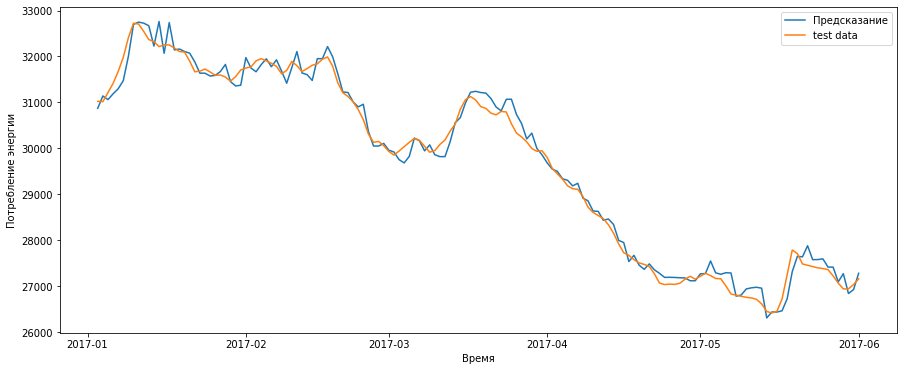

ошибка градиентного бустинга :   0.5105761337054509 %


In [21]:
plt.figure( figsize=(15, 6))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test.index[h:h+150], X_test_pred_gb[:150], label='Предсказание')
plt.plot(test.index[h:h+150], y_test_1[:150], label='test data')
#plt.plot(d_data.loc['2017-01-01':].index[h:], d_data.loc['2017-01-01':]['PJME_MW'].values[h:], label='исходный ряд')

plt.legend()
plt.show()

er_g_1 = mean_absolute_percentage_error(y_true=y_test_1, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g_1, '%')

Анализ на отсутствие корреляции с последующим ответом (проверяем не делаем ли предсказание в стиле "завтра==сегодня") 

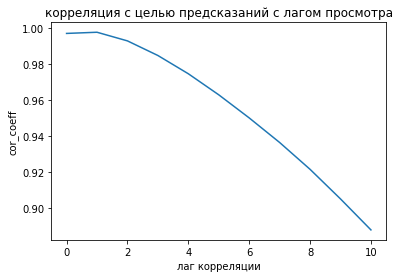

In [22]:
lag=10
p_cor=[np.corrcoef( y_test_1, X_test_pred_gb)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test_1[:-(i+1)], X_test_pred_gb[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()




In [23]:
print(np.round(p_cor,3))

[0.997 0.998 0.993 0.985 0.975 0.963 0.95  0.936 0.921 0.905 0.888]


Поскольку самое большое значение корреляции с первым ответом, то все хорошо

А Вот как плохо:

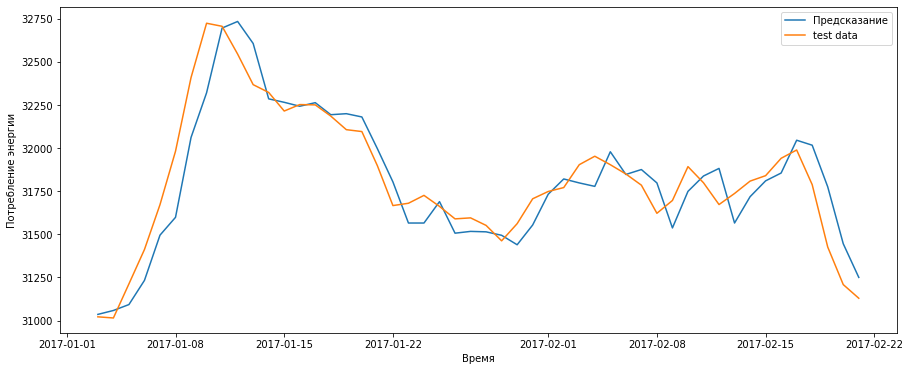

ошибка градиентного бустинга :   0.5299544829461083 %


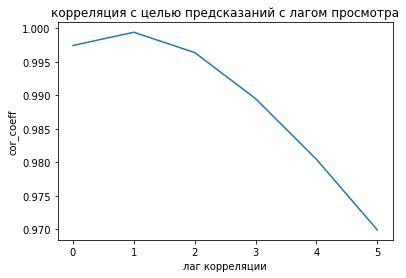

In [24]:
model_gb_no_good = GradientBoostingRegressor(max_depth=2, random_state=0, n_estimators=50)
model_gb_no_good.fit(X_train_1, y_train_1) 
X_test_pred_gb = model_gb_no_good.predict(X_test_1)
plt.figure( figsize=(15, 6))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test.index[h:h+50], X_test_pred_gb[:50], label='Предсказание')
plt.plot(test.index[h:h+50], y_test_1[:50], label='test data')
#plt.plot(d_data.loc['2017-01-01':].index[h:], d_data.loc['2017-01-01':]['PJME_MW'].values[h:], label='исходный ряд')

plt.legend()
plt.show()

er_g_1 = mean_absolute_percentage_error(y_true=y_test_1, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g_1, '%')


lag=5
p_cor=[np.corrcoef( y_test_1, X_test_pred_gb)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test_1[:-(i+1)], X_test_pred_gb[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

In [25]:
print(np.round(p_cor,3))

[0.997 0.999 0.996 0.99  0.98  0.97 ]


Это повторение "завира == сегодня" - плохой прогноз ( p_cor[1]- больше всех значений и почти 1)

### 1.5 прогноз  h = 10 - меняем глубину прогноза - это сложно и требует изменения набора признаков, но сейчас проверим, что покажет модель без изменения системы признаков. Оценим, как изменится ошибка прогнозирования при неизменных входах и увеличении глубины прогноза  

In [26]:
h = 10

In [27]:
X_train = train.iloc[:-h,:]
y_train = train[df.columns[0]].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[df.columns[0]].values[h:]

In [28]:
X_train = stsc.fit_transform(X_train)

X_test = stsc.transform(X_test)

In [29]:
model_gb = GradientBoostingRegressor(max_depth=20, random_state=0, n_estimators=100)
model_gb.fit( X_train, y_train ) 
X_test_pred_gb = model_gb.predict(X_test)

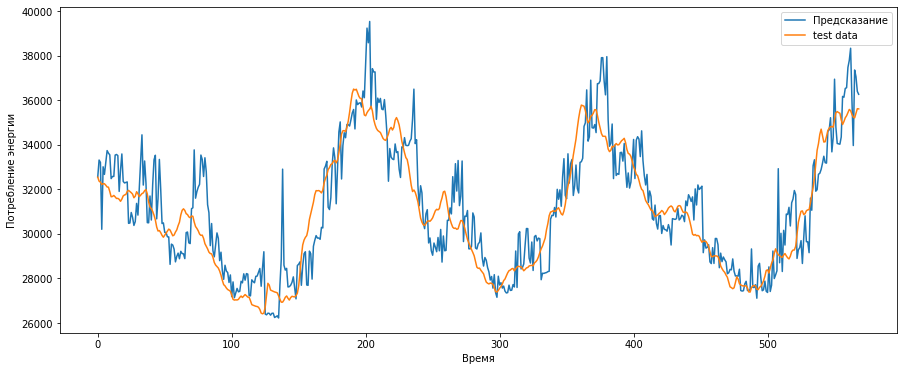

ошибка градиентного бустинга :   3.5469655431176985 %


In [30]:
plt.figure( figsize=(15, 6))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(X_test_pred_gb, label='Предсказание')
plt.plot(y_test, label='test data')
#plt.plot(d_data.loc['2017-01-01':].index[h:], d_data.loc['2017-01-01':]['PJME_MW'].values[h:], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

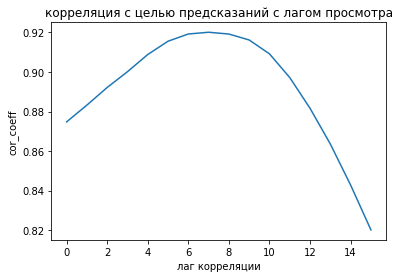

In [31]:

lag=h+5
p_cor=[np.corrcoef( y_test, X_test_pred_gb)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], X_test_pred_gb[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

In [32]:
print(np.round(p_cor,3))

[0.875 0.883 0.892 0.9   0.909 0.916 0.919 0.92  0.919 0.916 0.909 0.897
 0.882 0.864 0.843 0.82 ]


Плохой прогноз по всем параметрам и- это повтор

## 2. Оцените ошибку модели из п.1 .

In [33]:
print(f'Ошибка градиентного бустинга при h = 1 равна {er_g_1} %')

Ошибка градиентного бустинга при h = 1 равна 0.5299544829461083 %


In [34]:
print(f'Ошибка градиентного бустинга при h = 10 равна {er_g} %')

Ошибка градиентного бустинга при h = 10 равна 3.5469655431176985 %


## 3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

Ошибка сильно растет с увеличением h.
Для снижения ошибки будем в следующих ДЗ перестраивать систему признаков .
Нужно больше истории и нет смысла строить прогноз на h=10 по ряду без сглаживания ( скользящее среднее с окном 10). Все равно смотрим на 10 шагов вперед, имеет смысл перестроить модель и строить прогноз на один шаг , но по сжатой модели 


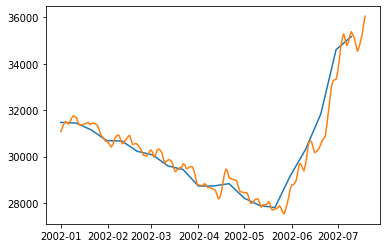

In [35]:
df_r=df.resample('10D').mean()
plt.plot(df_r.index[:20],df_r[0][:20])
plt.plot(df.index[:200], df[0][:200])
plt.show()

In [36]:
df_r.head()

,0,t0,t1,t2,t3,t4,t5,t6,t7,t8,...,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,31475.128271,28300.8,25125.6,21961.1,18810.9,15670.3,12524.0,9372.2,6231.9,3108.0,...,38.2,43.7,32.2,15.9,0.0,0.0,0.0,0.0,0.0,0.0
2002-01-11,31447.461370,31483.0,31510.4,31529.5,31537.4,31538.1,31547.7,31562.1,31566.2,31536.4,...,-9.4,-14.2,-3.9,29.8,61.8,65.7,67.1,56.5,42.2,32.6
2002-01-21,31149.577069,31219.8,31289.4,31347.3,31394.8,31417.3,31420.3,31417.9,31410.2,31420.3,...,-3.2,2.1,7.4,-10.2,-26.8,-35.9,-27.4,-19.1,-7.8,-0.6
2002-01-31,30690.909677,30681.8,30668.2,30663.4,30672.8,30715.9,30797.5,30895.9,30988.9,31071.8,...,-81.3,-98.0,-92.6,-82.6,-77.2,-70.6,-69.5,-58.0,-47.7,-22.7
2002-02-10,30672.540490,30690.6,30728.3,30768.5,30782.7,30765.4,30729.9,30695.8,30677.5,30680.7,...,35.3,34.0,18.2,-3.2,-9.6,8.8,13.7,4.9,-9.2,-42.9


In [37]:
trainr, testr = split_data(df_r, '2017-01-01')
h=1
X_trainr = trainr.iloc[:-h,:]
y_trainr = trainr[df_r.columns[0]].values[h:]
X_testr = testr.iloc[:-h,:]
y_testr = testr[df_r.columns[0]].values[h:]

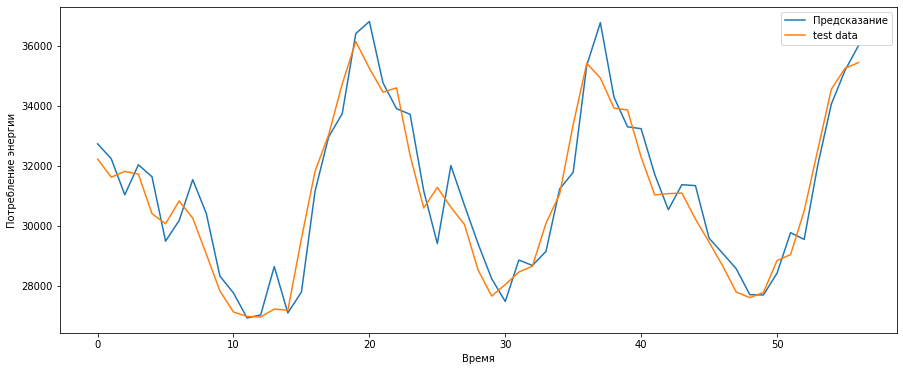

ошибка градиентного бустинга :   2.212482466918308 %


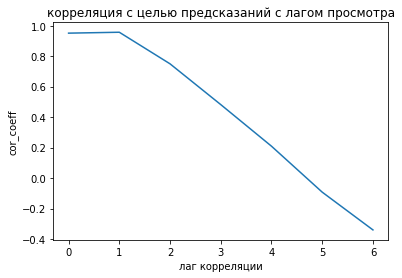

In [38]:
X_trainr = stsc.fit_transform(X_trainr)

X_testr = stsc.transform(X_testr)
model_gbr = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=200)
model_gbr.fit( X_trainr, y_trainr ) 
X_test_pred_gbr = model_gbr.predict(X_testr)

plt.figure( figsize=(15, 6))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(X_test_pred_gbr, label='Предсказание')
plt.plot(y_testr, label='test data')
#plt.plot(d_data.loc['2017-01-01':].index[h:], d_data.loc['2017-01-01':]['PJME_MW'].values[h:], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_testr, y_pred=X_test_pred_gbr)

print('ошибка градиентного бустинга :  ', er_g, '%')


lag=h+5
p_cor=[np.corrcoef( y_testr, X_test_pred_gbr)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_testr[:-(i+1)], X_test_pred_gbr[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

In [39]:
print(np.round(p_cor,3))

[ 0.951  0.957  0.75   0.482  0.209 -0.092 -0.34 ]
